For video check [here](https://www.youtube.com/watch?v=CbTU92pbDKw).

In [174]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Dataset for stock prices can be found [here](https://finance.yahoo.com/quote/MSFT/history/).

In [175]:
downloaded_file = tf.keras.utils.get_file(
    origin='https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=511056000&period2=1653523200&interval=1d&events=history&includeAdjustedClose=true',
    fname='MSFT.csv'
)

In [176]:
df = pd.read_csv(downloaded_file)

In [177]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400


In [178]:
df.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)

In [179]:
df.dtypes

Date         object
Open        float64
High        float64
Low         float64
Close       float64
AdjClose    float64
Volume        int64
dtype: object

In [180]:
df.describe()

,Open,High,Low,Close,AdjClose,Volume
count,9126.000000,9126.000000,9126.000000,9126.000000,9126.000000,9.126000e+03
mean,42.462836,42.912876,41.995467,42.468768,37.313501,5.862984e+07
std,61.822554,62.429561,61.150767,61.821474,62.032172,3.840608e+07
min,0.088542,0.092014,0.088542,0.090278,0.056745,2.304000e+06
25%,4.390625,4.455078,4.345703,4.387696,2.757909,3.447285e+07
50%,26.854688,27.140312,26.584999,26.870001,18.940775,5.191695e+07
75%,40.437500,40.961562,39.860001,40.343750,29.429416,7.245912e+07
max,344.619995,349.670013,342.200012,343.109985,341.606384,1.031789e+09


In [181]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [182]:
df.head()

,Date,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,,
1986-03-13,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1986-03-14,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
1986-03-17,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
1986-03-18,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
1986-03-19,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400


<AxesSubplot:xlabel='Date'>

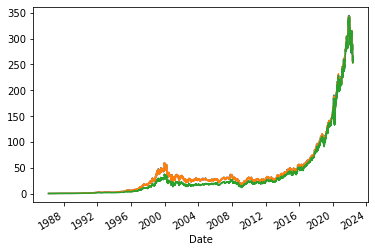

In [183]:
df.Open.plot()
df.Close.plot()
df.AdjClose.plot()

<AxesSubplot:xlabel='Date'>

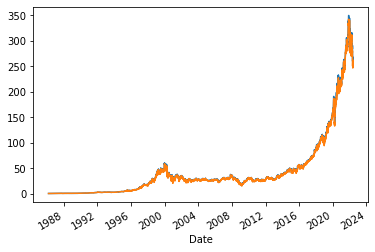

In [184]:
df.High.plot()
df.Low.plot()

In [185]:
new_df = df[['Close']]

In [186]:
new_df.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


In [187]:
new_df.index

DatetimeIndex(['1986-03-13', '1986-03-14', '1986-03-17', '1986-03-18',
               '1986-03-19', '1986-03-20', '1986-03-21', '1986-03-24',
               '1986-03-25', '1986-03-26',
               ...
               '2022-05-12', '2022-05-13', '2022-05-16', '2022-05-17',
               '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-23',
               '2022-05-24', '2022-05-25'],
              dtype='datetime64[ns]', name='Date', length=9126, freq=None)

In [188]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = datetime.datetime.strptime(first_date_str, '%Y-%m-%d')
    last_date = datetime.datetime.strptime(last_date_str, '%Y-%m-%d')

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
      df_subset = dataframe.loc[:target_date].tail(n+1)
      
      if len(df_subset) != n+1:
        print(f'Error: Window of size {n} is too large for date {target_date}')
        return

      values = df_subset['Close'].to_numpy()
      x, y = values[:-1], values[-1]

      dates.append(target_date)
      X.append(x)
      Y.append(y)

      next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
      next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
      next_date_str = next_datetime_str.split('T')[0]
      year_month_day = next_date_str.split('-')
      year, month, day = year_month_day
      next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
      
      if last_time:
        break
      
      target_date = next_date

      if target_date == last_date:
        last_time = True
      
    ret_df = pd.DataFrame({})
    ret_df['TargetDate'] = dates
    
    X = np.array(X)
    for i in range(0, n):
      X[:, i]
      ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df

In [189]:
windowed_df = df_to_windowed_df(
    df, 
    '2021-03-25', 
    '2022-03-23', 
    n=3
)

In [190]:
windowed_df.head()

,TargetDate,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004


In [191]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

In [192]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

In [193]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

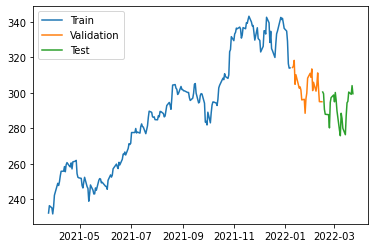

In [194]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [196]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((3, 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [197]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [198]:
model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mean_absolute_error']
)

In [199]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/1000
7/7 [==============================] - 1s 56ms/step - loss: 84757.7734 - mean_absolute_error: 289.3926 - val_loss: 92456.9297 - val_mean_absolute_error: 303.9802
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 84535.9609 - mean_absolute_error: 289.0080 - val_loss: 92241.0234 - val_mean_absolute_error: 303.6248
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 84315.3516 - mean_absolute_error: 288.6255 - val_loss: 91962.5312 - val_mean_absolute_error: 303.1659
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 84022.9219 - mean_absolute_error: 288.1213 - val_loss: 91621.7891 - val_mean_absolute_error: 302.6034
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 83648.9453 - mean_absolute_error: 287.4657 - val_loss: 91111.8203 - val_mean_absolute_error: 301.7596
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 83077.7656 - mean_absolute_error: 286.4680 - val_loss: 90

In [200]:
train_predictions = model.predict(X_train).flatten()

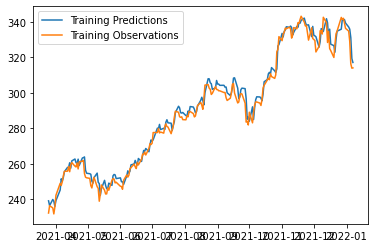

In [201]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

In [202]:
val_predictions = model.predict(X_val).flatten()

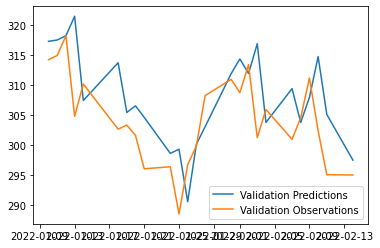

In [203]:
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [204]:
test_predictions = model.predict(X_test).flatten()

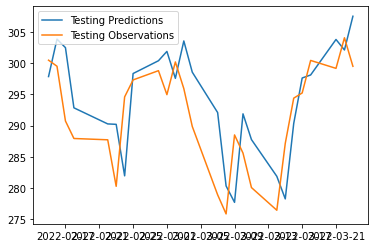

In [205]:
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

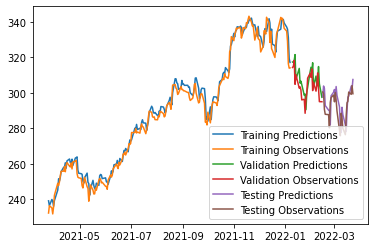

In [206]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend([
    'Training Predictions', 
    'Training Observations',
    'Validation Predictions', 
    'Validation Observations',
    'Testing Predictions', 
    'Testing Observations'
])

In [207]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

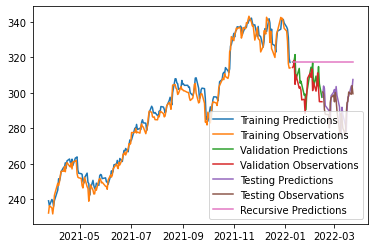

In [208]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend([
    'Training Predictions', 
    'Training Observations',
    'Validation Predictions', 
    'Validation Observations',
    'Testing Predictions', 
    'Testing Observations',
    'Recursive Predictions'
])